# 라이브러리

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,137 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and d

In [2]:
import numpy as np
import pandas as pd
import datetime as datetime
# import dataload
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
tqdm.pandas()
pd.set_option('display.max_rows', 500)

In [54]:
cd /content/drive/MyDrive/2021/날씨공모전/code

/content/drive/MyDrive/2021/날씨공모전/code


# 0. 데이터 로드

## 0-1. qty, 날씨, cnt

In [3]:
data = pd.read_csv('../data/final_0613.csv', encoding='cp949')

In [4]:
data['date'] = data['date'].apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d'))
data['year'] = data['date'].apply(lambda x : x.year)

In [5]:
data.head()

,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50,year
0,2018-01-01,1,식품,가공란,37.0,0.0,10.69387,4.09137,0.00000,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2018
1,2018-01-01,1,식품,가공란,16.0,0.0,12.42969,6.35294,0.00000,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2018
2,2018-01-01,1,식품,가공란,9.0,0.0,13.02249,4.88037,0.00000,0.40650,0.00000,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2018
3,2018-01-01,1,식품,가공란,3.0,0.0,11.69080,4.53350,1.21951,0.90909,0.00000,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2018
4,2018-01-01,0,식품,가공란,13.0,0.0,11.23032,3.61296,0.38910,2.22222,0.04060,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2018


## 0-2. 정상 / 비정상 구분  
* ADF Test

In [7]:
def normalization(data):
    avg_lst = []; std_lst = []
    for idx, item in tqdm(data.iteritems()):
        avg_lst.append(item.mean())
        std_lst.append(item.std())

    for i in tqdm(range(data.shape[1])):
        for j in range(365):
            data.iloc[j,i] = (data.iloc[j,i] - avg_lst[i])/std_lst[i]

    return data

In [24]:
adf_data = data[['date', 'sm_cat', 'qty']].groupby(['date', 'sm_cat']).sum().reset_index()
adf_data = pd.pivot_table(adf_data, values='qty', index='date', columns='sm_cat').fillna(0)
adf_data.head()

sm_cat,가공란,가스온수기,가열식 가습기,가자미,갈비/찜/바비큐용 돈육,갈비용 우육,갈치,감/홍시,감귤/한라봉/오렌지,감마리놀렌산 영양제,감말랭이,감자,갓김치,건강즙,건강즙/녹용,건대추,건망고,건바나나,건어물 건새우,건어물 노가리,건어물 마른오징어,건어물 멸치,건어물 쥐포,건어물 진미채,건어물 황태,건자두,건포도,게장류,견과류,견과류 땅콩,견과류 마카다미아,견과류 밤,견과류 잣/은행,견과류 카카오닙스,견과류 캐슈넛,견과류 피스타치오,견과류 호두,계란,고등어,고추/피망/파프리카,...,한방재료,한우육,해조류 다시마,해조류 미역,해초류,핸드워시/스크럽,핸드크림,향수세트,허브차,헛개/가시오가피,헤어 브러쉬,헤어매니큐어,헤어무스,헤어스타일링용 염색약,헤어스타일링용 펌제,헤어스타일링용 흑채,헤어스프레이,헤어에센스,헤어왁스,헤어젤,헤어케어세트,호박,혼합견과,혼합곡,홍삼 간식,홍삼 분말/환,홍삼 음료,홍삼/인삼 제품,홍삼액/홍삼정,홍삼절편/홍삼정과,홍어,홍차,화장 비누,화장 퍼프,환자식,황토매트,회,휴대용 선풍기,흰우유,히터
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,90.0,0.0,7.0,21.0,22.0,2.0,43.0,50.0,883.0,34.0,27.0,206.0,26.0,46.0,70.0,23.0,5.0,20.0,3.0,5.0,184.0,60.0,69.0,16.0,47.0,37.0,5.0,127.0,256.0,32.0,22.0,129.0,11.0,47.0,4.0,6.0,45.0,119.0,91.0,62.0,...,29.0,169.0,21.0,50.0,65.0,71.0,351.0,0.0,140.0,7.0,64.0,5.0,1.0,287.0,38.0,54.0,35.0,408.0,48.0,5.0,40.0,76.0,70.0,0.0,9.0,26.0,4.0,100.0,957.0,68.0,7.0,30.0,216.0,118.0,48.0,4.0,847.0,1.0,600.0,119.0
2018-01-02,132.0,0.0,23.0,16.0,7.0,2.0,86.0,60.0,1019.0,27.0,32.0,216.0,35.0,105.0,115.0,29.0,3.0,17.0,6.0,4.0,208.0,70.0,83.0,25.0,81.0,36.0,28.0,74.0,247.0,39.0,27.0,423.0,19.0,59.0,17.0,11.0,72.0,155.0,372.0,88.0,...,58.0,205.0,30.0,74.0,88.0,137.0,413.0,2.0,283.0,12.0,87.0,16.0,4.0,327.0,95.0,38.0,77.0,445.0,94.0,26.0,45.0,105.0,96.0,1.0,15.0,40.0,13.0,337.0,476.0,207.0,5.0,56.0,343.0,129.0,48.0,6.0,974.0,4.0,804.0,287.0
2018-01-03,113.0,0.0,12.0,17.0,5.0,2.0,358.0,51.0,1007.0,44.0,28.0,234.0,19.0,73.0,84.0,29.0,9.0,25.0,6.0,11.0,233.0,88.0,81.0,23.0,56.0,37.0,1.0,78.0,165.0,46.0,41.0,129.0,19.0,54.0,6.0,4.0,70.0,149.0,186.0,92.0,...,74.0,209.0,20.0,64.0,39.0,96.0,392.0,1.0,210.0,2.0,96.0,8.0,5.0,315.0,94.0,50.0,70.0,408.0,87.0,5.0,45.0,112.0,107.0,0.0,18.0,31.0,8.0,142.0,509.0,78.0,7.0,39.0,332.0,138.0,49.0,7.0,1287.0,1.0,698.0,284.0
2018-01-04,102.0,0.0,15.0,12.0,13.0,1.0,77.0,58.0,878.0,33.0,30.0,199.0,28.0,64.0,135.0,24.0,10.0,22.0,6.0,21.0,177.0,89.0,93.0,23.0,57.0,34.0,7.0,72.0,186.0,46.0,24.0,179.0,14.0,45.0,8.0,14.0,72.0,137.0,242.0,109.0,...,78.0,144.0,30.0,60.0,61.0,95.0,337.0,0.0,175.0,7.0,65.0,10.0,0.0,332.0,61.0,32.0,62.0,391.0,73.0,12.0,30.0,99.0,75.0,4.0,9.0,38.0,7.0,141.0,528.0,60.0,20.0,39.0,301.0,138.0,65.0,7.0,1424.0,3.0,602.0,242.0
2018-01-05,89.0,0.0,18.0,24.0,9.0,2.0,62.0,48.0,1078.0,18.0,23.0,160.0,21.0,49.0,82.0,31.0,5.0,17.0,3.0,22.0,169.0,64.0,365.0,22.0,41.0,31.0,6.0,40.0,160.0,35.0,19.0,104.0,26.0,26.0,9.0,9.0,45.0,101.0,170.0,81.0,...,41.0,138.0,30.0,60.0,240.0,120.0,296.0,0.0,336.0,7.0,109.0,23.0,3.0,297.0,64.0,48.0,45.0,357.0,81.0,8.0,28.0,91.0,67.0,0.0,20.0,41.0,11.0,118.0,581.0,55.0,4.0,44.0,202.0,153.0,46.0,7.0,1340.0,3.0,558.0,242.0


In [46]:
from statsmodels.tsa.stattools import adfuller
adf_res = pd.DataFrame()
sm_cat_list = list(adf_data.columns)

def adf_test(data, sm_cat):
    item = data[sm_cat]
    result = adfuller(item.values)
    if result[1] <= 0.05:
        test_res = '정상' # 기각
    else:
        test_res = '비정상' 
    return pd.DataFrame([{'sm_cat':sm_cat, 'ADF_stats':result[0], 'p-value':result[1], 'test_res':test_res}])

for sm_cat in sm_cat_list:
    adf_res = pd.concat([adf_res, adf_test(adf_data, sm_cat)], axis=0)

In [26]:
adf_res.head()

,sm_cat,ADF_stats,p-value,test_res
0,가공란,-2.975776,3.721936e-02,정상
0,가스온수기,-6.023157,1.477180e-07,정상
0,가열식 가습기,-1.022512,7.449652e-01,비정상
0,가자미,-3.825008,2.661567e-03,정상
0,갈비/찜/바비큐용 돈육,-2.474989,1.216789e-01,비정상


In [27]:
adf_res.test_res.value_counts()

정상     229
비정상    154
Name: test_res, dtype: int64

In [47]:
adf_res[adf_res.test_res=='정상'].sm_cat.unique()

array(['가공란', '가스온수기', '가자미', '갈치', '감/홍시', '감마리놀렌산 영양제', '감말랭이', '갓김치',
       '건강즙/녹용', '건망고', '건바나나', '건어물 건새우', '건어물 노가리', '건어물 마른오징어',
       '건어물 멸치', '건어물 쥐포', '건어물 황태', '건자두', '견과류', '견과류 땅콩', '견과류 마카다미아',
       '견과류 잣/은행', '견과류 캐슈넛', '견과류 피스타치오', '견과류 호두', '계란', '고등어',
       '공기정화 용품', '공기청정기', '곶감/반건시', '과실차', '과일세트', '과일채소 분말/분태',
       '과채 음료/주스', '구이/수육용 돈육', '굴비/조기', '글루코사민/키토산 영양제', '기능성 링클케어 화장품',
       '기능성 모공관리 화장품', '기능성 영양보습 화장품', '기능성 트러블케어 화장품', '기능성 화이트닝 화장품',
       '기초 화장용 스킨', '기초 화장용 에센스', '기초 화장용 오일/앰플', '기타 농산물', '기타 한방/환제품',
       '꽃게', '나물', '낙지', '남성 메이크업', '남성 스킨', '남성 에센스', '남성 크림', '남성 클렌징',
       '남성향수', '냉풍기', '네일 메이크업 용품', '네일관리 소품', '네일리무버', '네일세트', '네일아트',
       '네일컬러', '네일케어', '녹차', '닭 양념육', '닭가슴살', '더치커피', '도라지/더덕', '돈풍기',
       '두유', '랍스타', '레몬/자몽', '린스', '립앤아이 리무버', '마/야콘', '멀티형 에어컨',
       '메이크업 박스', '무/배추', '문어', '미용가위', '바나나/파인애플/망고', '바디 세트', '바디 스크럽',
       '바디케어용 때비누', '바디케어용 볼륨업크림', '바디케어용 슬리밍', '바디케어용 청 결제', '반건조고구마',
      

In [48]:
adf_res[adf_res.test_res=='비정상'].sm_cat.unique()

array(['가열식 가습기', '갈비/찜/바비큐용 돈육', '갈비용 우육', '감귤/한라봉/오렌지', '감자', '건강즙',
       '건대추', '건어물 진미채', '건포도', '게장류', '견과류 밤', '견과류 카카오닙스', '고추/피망/파프리카',
       '곡물차', '과일류', '국내산 돈육', '굴 생물', '기능성 아이케어 화장품', '기능성 화장품 세트',
       '기초 화장용 로션', '기초 화장용 미스트', '기초 화장용 크림', '기타 주스류', '김치류', '난방용 열풍기',
       '남성 로션', '남성 선케어', '남성 세트', '남성 쉐이빙', '느타리버섯', '다이어트보조식',
       '다이어트용 헬스보충식품', '대게/킹크랩', '데오드란트', '돼지 곱창', '둥굴레차', '딸기/복분자/블루베리',
       '딸기우유', '라디에이터', '루테인/눈 영양제', '마늘/생강', '메이크업 브러쉬', '메추리알', '명태/동태',
       '무김치', '물김치', '미나리', '미숫가루/곡물가루', '믹스 채소', '밀크티/티라떼', '바나나우유',
       '바디 보습제', '바디 클렌져', '바디케어용 땀패드', '바디케어용 제모제', '배추김치', '벽걸이 에어컨',
       '벽걸이형 선풍기', '보리차', '복합식 가습기', '부추', '뷰티 타투', '뷰티 화장품 공병/케이스',
       '뷰티용 면봉/귀이개', '브로콜리/셀러리', '비타민', '비타민/화이바 음료', '새송이버섯', '새우/대하',
       '색조 메이크업 립밤', '색조 메이크업 립틴트', '색조 메이크업 아이섀도우', '샴푸', '선로션', '선스프레이',
       '선케어용 선밤', '선파우더', '소고기 육회', '손톱정리도구', '숙취/에너지/건강 음료', '시금치',
       '쌈채소', '아이스티', '애프터선', '야채/호박즙', '양배추/양상추', '어린이 음료', '어린이영양제'

In [28]:
group_data = adf_res[['sm_cat', 'test_res']] # 정상 / 비정상

In [54]:
# group_data.to_csv('../data/adf_res.csv', encoding='cp949')

## 0-3. 집단별 데이터

In [55]:
adf_corr = pd.read_csv('../data/adf_corr_group_0617.csv', encoding='cp949')

In [57]:
adf_corr.head()

,big_cat,sm_cat,group
0,식품,감귤/한라봉/오렌지,비정상_high
1,냉난방가전,복합식 가습기,비정상_high
2,냉난방가전,초음파식 가습기,비정상_high
3,식품,굴 생물,비정상_high
4,냉난방가전,에어워셔,비정상_high


In [61]:
adf_corr.group.value_counts()

비정상_high    134
정상_high     130
정상_low       99
비정상_low      20
Name: group, dtype: int64

In [58]:
final_data = data.merge(adf_corr[['sm_cat', 'group']], on='sm_cat')

In [59]:
final_data.head()

,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50,year,group
0,2018-01-01,1,식품,가공란,37.0,0.0,10.69387,4.09137,0.00000,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2018,정상_low
1,2018-01-01,1,식품,가공란,16.0,0.0,12.42969,6.35294,0.00000,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2018,정상_low
2,2018-01-01,1,식품,가공란,9.0,0.0,13.02249,4.88037,0.00000,0.40650,0.00000,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2018,정상_low
3,2018-01-01,1,식품,가공란,3.0,0.0,11.69080,4.53350,1.21951,0.90909,0.00000,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2018,정상_low
4,2018-01-01,0,식품,가공란,13.0,0.0,11.23032,3.61296,0.38910,2.22222,0.04060,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2018,정상_low


## ==== 재연결 여기에서 ====

In [4]:
# final_data.to_csv('../data/final_0617.csv', encoding='cp949')

final_data = pd.read_csv('../data/final_0617.csv', encoding='cp949').iloc[:,1:]
final_data['date'] = final_data['date'].apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d'))

In [5]:
# sh_data : [정상, high corr]
# ush_data : [비정상, high corr]
# sl_data : [정상, low corr]
# usl_data : [비정상, low corr]

sh_data = final_data[final_data.group=='정상_high']
ush_data = final_data[final_data.group=='비정상_high']
sl_data = final_data[final_data.group=='정상_low']
usl_data = final_data[final_data.group=='비정상_low']

# 정상 데이터 => VAR
# 비정상 데이터 => 공적분 관계가 존재하면 VECM

sh = sh_data[['date', 'sm_cat', 'qty']].groupby(['date', 'sm_cat']).sum().reset_index()
sh = pd.pivot_table(sh, values='qty', index='date', columns='sm_cat').fillna(0)
ush = ush_data[['date', 'sm_cat', 'qty']].groupby(['date', 'sm_cat']).sum().reset_index()
ush = pd.pivot_table(ush, values='qty', index='date', columns='sm_cat').fillna(0)

# qty와 상관관계가 높은 데이터만 사용
sh_item = list(sh.columns) # sm_cat
ush_item = list(ush.columns) # sm_cat

# 정규화 안함
ush.head()

sm_cat,가열식 가습기,갈비/찜/바비큐용 돈육,감귤/한라봉/오렌지,감자,건대추,건어물 진미채,건포도,게장류,견과류 밤,고추/피망/파프리카,곡물차,과일류,국내산 돈육,굴 생물,기능성 아이케어 화장품,기능성 화장품 세트,기초 화장용 로션,기초 화장용 미스트,기초 화장용 크림,기타 주스류,김치류,난방용 열풍기,남성 로션,남성 선케어,남성 세트,남성 쉐이빙,느타리버섯,다이어트보조식,다이어트용 헬스보충식품,대게/킹크랩,데오드란트,둥굴레차,딸기/복분자/블루베리,딸기우유,라디에이터,루테인/눈 영양제,마늘/생강,메이크업 브러쉬,명태/동태,무김치,...,저/무지방우유,전기온수기,전기장판,전통차,조개,주꾸미,참외/메론/수박,초음파식 가습기,초코우유,카페트매트,칼슘/철분 영양제,캡슐/POD커피,컨벡터,코코아/핫초코,콜라겐/코큐텐 영양제,클렌징 로션,클렌징 티슈,탁상/USB 선풍기,탄산수,탄산음료,토마토,파/양파,파김치,포도/거봉/체리,프로바이오틱스,프로폴리스/로얄젤리,해초류,핸드워시/스크럽,핸드크림,허브차,헤어 브러쉬,헤어스타일링용 흑채,헤어스프레이,헤어에센스,호박,홍차,환자식,황토매트,휴대용 선풍기,히터
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,7.0,22.0,883.0,206.0,23.0,16.0,5.0,127.0,129.0,62.0,72.0,57.0,25.0,90.0,364.0,9.0,500.0,128.0,3025.0,136.0,144.0,0.0,99.0,5.0,121.0,41.0,14.0,745.0,84.0,23.0,24.0,27.0,107.0,53.0,10.0,249.0,51.0,198.0,8.0,61.0,...,106.0,8.0,69.0,542.0,190.0,50.0,30.0,252.0,137.0,11.0,143.0,148.0,19.0,104.0,193.0,18.0,47.0,0.0,204.0,825.0,130.0,107.0,14.0,14.0,333.0,109.0,65.0,71.0,351.0,140.0,64.0,54.0,35.0,408.0,76.0,30.0,48.0,4.0,1.0,119.0
2018-01-02,23.0,7.0,1019.0,216.0,29.0,25.0,28.0,74.0,423.0,88.0,90.0,95.0,49.0,125.0,324.0,14.0,645.0,185.0,3581.0,180.0,182.0,0.0,114.0,6.0,126.0,62.0,30.0,842.0,115.0,32.0,47.0,59.0,154.0,80.0,31.0,324.0,99.0,212.0,15.0,88.0,...,129.0,14.0,86.0,388.0,192.0,59.0,42.0,399.0,150.0,15.0,253.0,278.0,18.0,176.0,182.0,38.0,56.0,4.0,181.0,696.0,179.0,125.0,7.0,27.0,520.0,168.0,88.0,137.0,413.0,283.0,87.0,38.0,77.0,445.0,105.0,56.0,48.0,6.0,4.0,287.0
2018-01-03,12.0,5.0,1007.0,234.0,29.0,23.0,1.0,78.0,129.0,92.0,77.0,109.0,39.0,171.0,415.0,10.0,596.0,207.0,2934.0,168.0,185.0,0.0,86.0,10.0,147.0,59.0,38.0,700.0,105.0,28.0,39.0,85.0,139.0,61.0,23.0,285.0,67.0,208.0,13.0,74.0,...,116.0,12.0,75.0,256.0,177.0,56.0,52.0,412.0,114.0,9.0,243.0,230.0,29.0,140.0,123.0,28.0,42.0,2.0,204.0,706.0,161.0,149.0,10.0,22.0,467.0,160.0,39.0,96.0,392.0,210.0,96.0,50.0,70.0,408.0,112.0,39.0,49.0,7.0,1.0,284.0
2018-01-04,15.0,13.0,878.0,199.0,24.0,23.0,7.0,72.0,179.0,109.0,78.0,77.0,35.0,177.0,657.0,21.0,535.0,174.0,2655.0,140.0,157.0,1.0,102.0,7.0,102.0,54.0,18.0,639.0,106.0,36.0,43.0,65.0,137.0,55.0,33.0,234.0,87.0,269.0,13.0,63.0,...,112.0,17.0,67.0,283.0,187.0,52.0,38.0,494.0,135.0,12.0,223.0,233.0,30.0,144.0,120.0,29.0,37.0,1.0,193.0,685.0,118.0,139.0,6.0,23.0,339.0,116.0,61.0,95.0,337.0,175.0,65.0,32.0,62.0,391.0,99.0,39.0,65.0,7.0,3.0,242.0
2018-01-05,18.0,9.0,1078.0,160.0,31.0,22.0,6.0,40.0,104.0,81.0,70.0,73.0,40.0,229.0,643.0,43.0,531.0,134.0,3063.0,134.0,152.0,1.0,88.0,1.0,143.0,51.0,30.0,557.0,71.0,22.0,30.0,56.0,96.0,47.0,23.0,207.0,70.0,197.0,11.0,78.0,...,76.0,14.0,64.0,223.0,156.0,59.0,26.0,320.0,146.0,15.0,170.0,146.0,19.0,114.0,170.0,28.0,49.0,3.0,178.0,682.0,132.0,111.0,8.0,19.0,641.0,112.0,240.0,120.0,296.0,336.0,109.0,48.0,45.0,357.0,91.0,44.0,46.0,7.0,3.0,242.0


## 0-4. 날씨 데이터

In [6]:
var_list = ['date', 'avg_ta', 'max_ta', 'min_ta', 'avg_ws', 'PM10', 'PM25', 'hm_max', 'sum_ss_hr', 'max_pa']
weather = sh_data.groupby(['date']).mean().reset_index()[var_list]
weather.index = weather['date']
weather = weather.drop('date', axis=1)
weather.head()

,avg_ta,max_ta,min_ta,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa
date,,,,,,,,,
2018-01-01,0.885198,5.464146,-2.880740,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385
2018-01-02,1.208896,6.014385,-3.135167,1.903604,59.179487,33.836826,74.169781,37.996677,1021.524802
2018-01-03,-0.798604,3.236083,-3.619615,2.623562,32.757902,18.242391,59.310396,53.216885,1023.277500
2018-01-04,-1.075625,2.345708,-4.636646,1.842729,38.685406,23.045234,63.961750,33.707167,1021.539615
2018-01-05,0.584646,5.053948,-2.273062,2.280938,46.151746,30.785155,71.747365,40.403240,1014.525396


# 1. 모델링

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM

## 1-1. 정상성 확인

### 1-1-1. sh의 qty

In [131]:
# ===== ADF 확인 =====
adf_sh = pd.DataFrame()

def adf_test(data, sm_cat):
    item = data[sm_cat]
    result = adfuller(item.values)
    if result[1] <= 0.05:
        test_res = '정상' # 기각
    else:
        test_res = '비정상' # 기각하지 못함 
    return pd.DataFrame([{'sm_cat':sm_cat, 'ADF_stats':result[0], 'p-value':result[1], 'test_res':test_res}])

for sm_cat in sh_item:
    adf_sh = pd.concat([adf_sh, adf_test(sh, sm_cat)], axis=0)

In [132]:
adf_sh.test_res.value_counts()

정상    130
Name: test_res, dtype: int64

### 1-1-2. weather raw

In [142]:
weather_var = list(weather.columns) # weather
adf_w = pd.DataFrame()

for w in weather_var:
    adf_w = pd.concat([adf_w, adf_test(weather, w)], axis=0)

In [143]:
adf_w

,sm_cat,ADF_stats,p-value,test_res
0,avg_ta,-1.159773,6.906567e-01,비정상
0,max_ta,-1.292596,6.325528e-01,비정상
0,min_ta,-1.420047,5.726284e-01,비정상
0,avg_ws,-8.447146,1.700688e-13,정상
0,PM10,-5.178100,9.743812e-06,정상
0,PM25,-8.307779,3.861735e-13,정상
0,hm_max,-2.183893,2.121433e-01,비정상
0,sum_ss_hr,-8.254599,5.278634e-13,정상
0,max_pa,-2.118257,2.372370e-01,비정상


### 1-1-3. weather diff (1차 차분)  
모두 정상

In [137]:
weather_var = list(weather.columns) # weather
adf_diff_w = pd.DataFrame()

for w in weather_var:
    adf_diff_w = pd.concat([adf_diff_w, adf_test(weather.diff(1)[1:], w)], axis=0)

In [138]:
adf_diff_w

,sm_cat,ADF_stats,p-value,test_res
0,avg_ta,-6.411984,1.880972e-08,정상
0,max_ta,-6.773067,2.611996e-09,정상
0,min_ta,-13.612783,1.859437e-25,정상
0,avg_ws,-10.233634,4.954110e-18,정상
0,PM10,-10.342656,2.660259e-18,정상
0,PM25,-10.015238,1.735885e-17,정상
0,hm_max,-10.167680,7.226527e-18,정상
0,sum_ss_hr,-10.135348,8.698942e-18,정상
0,max_pa,-14.425724,7.778124e-27,정상


## 1-2. 정상 qty 
* `sh` = stationary, high corr 

### 1-2-1. 정상 `qty`와 정상 날씨

#### VAR & Granger

In [8]:
st_weather = ['avg_ws', 'PM10', 'PM25', 'sum_ss_hr']
nst_weather = ['avg_ta', 'max_ta', 'min_ta', 'hm_max', 'max_pa']

In [9]:
def VAR_granger(data, weather, sm_cat, w_var):
    x = pd.concat([weather[w_var], data[sm_cat]], axis=1)
    forecasting_model = VAR(x)
    results_aic = []
    for p in range(1,10):
        results = forecasting_model.fit(p)
        results_aic.append(results.aic)
    model = VAR(x)
    lag = np.argmin(results_aic) + 1
    var_res = model.fit(lag)
    g_res = var_res.test_causality(caused=sm_cat, causing=w_var)
    if g_res.pvalue <= 0.05:
        reject = 'causality'
    else:
        reject = 'None'
    return pd.DataFrame([{'sm_cat':sm_cat, 'weather':w_var, 'var_lag':lag, 'granger_reject':reject}])

In [28]:
warnings.filterwarnings('ignore')
sh_var_res = pd.DataFrame()

for w in st_weather:
    for sm_cat in sh_item:
        result = VAR_granger(sh, weather, sm_cat, w)
        sh_var_res = pd.concat([sh_var_res, result], axis=0)

In [29]:
for w in st_weather:
    print('===== Granger Causality : {} ====='.format(w))
    print(sh_var_res.loc[sh_var_res.weather==w, 'granger_reject'].value_counts())
    print(' ')

===== Granger Causality : avg_ws =====
None         117
causality     13
Name: granger_reject, dtype: int64
 
===== Granger Causality : PM10 =====
None         105
causality     25
Name: granger_reject, dtype: int64
 
===== Granger Causality : PM25 =====
None         111
causality     19
Name: granger_reject, dtype: int64
 
===== Granger Causality : sum_ss_hr =====
None         115
causality     15
Name: granger_reject, dtype: int64
 


In [30]:
sh_var_pivot = pd.pivot_table(sh_var_res, index='sm_cat', values='granger_reject', columns='weather', aggfunc='first')
sh_var_pivot

weather,PM10,PM25,avg_ws,sum_ss_hr
sm_cat,,,,
가스온수기,causality,None,None,None
가자미,None,None,None,None
감/홍시,None,None,None,None
감말랭이,None,None,None,causality
갓김치,causality,None,None,None
건강즙/녹용,None,None,None,None
건어물 멸치,None,None,None,None
건어물 황태,None,None,None,None
건자두,None,None,None,None


In [31]:
# VAR 모델링 예시 (PM25, 공기청정기)
sh_var_res[sh_var_res.sm_cat=='공기청정기']

,sm_cat,weather,var_lag,granger_reject
0,공기청정기,avg_ws,5,None
0,공기청정기,PM10,1,causality
0,공기청정기,PM25,4,causality
0,공기청정기,sum_ss_hr,1,None


In [97]:
x = pd.concat([weather['PM25'], sh['공기청정기']], axis=1)
forecasting_model = VAR(x)
res = forecasting_model.fit(4)

In [116]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Jun, 2021
Time:                     11:55:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.8606
Nobs:                     726.000    HQIC:                   13.7908
Log likelihood:          -7032.41    FPE:                    933665.
AIC:                      13.7469    Det(Omega_mle):         910939.
--------------------------------------------------------------------
Results for equation PM25
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            4.421075         0.675582            6.544           0.000
L1.PM25          0.958681         0.038099           25.163           0.000
L1.공기청정기         0.002132         0.002042            1.044           0.297
L2.PM

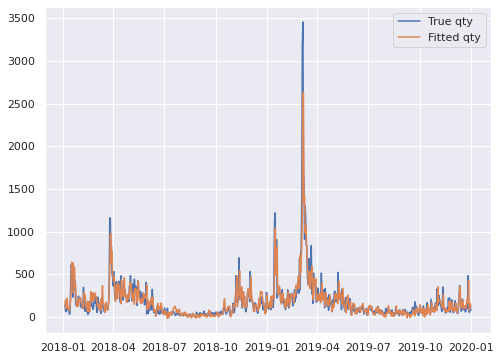

In [147]:
x_len = sh['공기청정기'][4:].index
sns.set()
plt.figure(figsize=(8,6))
plt.plot(x_len, sh['공기청정기'][4:], label="True qty")
plt.plot(x_len, res.fittedvalues['공기청정기'], label="Fitted qty") #적합값..
plt.legend(loc='upper right')

### 1-2-2. 정상 `qty`와 비정상 날씨  

**공적분 검정(Cointegration Test) / VECM**
> **공적분 관계**  
  * 두 비정상적 시계열 x, y의 결합에 의해 생기는 잔차 e가 정상이면, 유의한 공적분 관계가 존재함을 의미  
  * x, y간 장기적인 균형관계 (장기적으로 봤을 때 서로 영향을 적당히 미친다)
  공적분 관계가 성립함을 확인한 후, VECM으로 예측  
  * rank=0 : p-vector의 경우 p개의 단위근을 가지는 불안정한 시계열 = 비정상 시계열

#### 공적분 검정

In [10]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests

In [11]:
def co_test(data, weather, sm_cat, w_var):
    score, p_value, _ = coint(data[sm_cat], weather[w_var]) # coint(y, x)
    if p_value <= 0.05:
        test_res = '공적분' # 장기적으로 유의한 관계가 있다
    else:
        test_res = 'None' # 장기적으로 유의한 관계가 없다
    return pd.DataFrame([{'sm_cat':sm_cat, w_var:test_res}])

In [32]:
sh_co_res = pd.DataFrame()
for i in range(len(nst_weather)):
    w_sample = weather[nst_weather[i]]
    res = pd.DataFrame()
    for sm_cat in sh_item:
        res = pd.concat([res, co_test(sh, weather, sm_cat, nst_weather[i])], axis=0)
    if i == 0:
        sh_co_res = pd.concat([sh_co_res, res], axis=1)
    else:
        sh_co_res = pd.concat([sh_co_res, res.drop(['sm_cat'], axis=1)], axis=1)

In [33]:
sh_co_res # 정상qty와 비정상날씨 간 공적분이 존재할 경우, vecm 적합 가능

,sm_cat,avg_ta,max_ta,min_ta,hm_max,max_pa
0,가스온수기,공적분,공적분,공적분,공적분,공적분
0,가자미,공적분,공적분,공적분,공적분,공적분
0,감/홍시,공적분,공적분,공적분,공적분,공적분
0,감말랭이,공적분,공적분,공적분,공적분,공적분
0,갓김치,공적분,공적분,공적분,공적분,공적분
0,건강즙/녹용,공적분,공적분,공적분,공적분,공적분
0,건어물 멸치,공적분,공적분,공적분,공적분,공적분
0,건어물 황태,공적분,공적분,공적분,공적분,공적분
0,건자두,공적분,공적분,공적분,공적분,공적분
0,견과류,공적분,공적분,공적분,공적분,공적분


#### VECM & Granger

In [12]:
from io import StringIO 
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [13]:
def VECM_granger(data, weather, sm_cat, w_var):
    x = pd.concat([weather[w_var], data[sm_cat]], axis=1)
    vec_rank = select_coint_rank(x, det_order = -1, k_ar_diff = 2, method = 'trace', signif=0.01).rank
    model = VECM(x, k_ar_diff=2, coint_rank=vec_rank)
    vecm_res = model.fit()
    g_res = vecm_res.test_granger_causality(caused=sm_cat, causing=w_var)
    with Capturing() as output:
        print(g_res.summary()[1][2])
    if float(output[0]) <= 0.05:
        reject = 'causality'
    else:
        reject = 'None'
    return pd.DataFrame([{'sm_cat':sm_cat, 'weather':w_var, 'granger_reject':reject}])

In [44]:
warnings.filterwarnings('ignore')
sh_vecm_res = pd.DataFrame()

for w_var in nst_weather:
    for sm_cat in sh_item:
        # 공적분 관계가 유의할 때, 그래인저 인과관계 분석
        if (sh_co_res.loc[sh_co_res.sm_cat==sm_cat, w_var] == '공적분').values: 
            result = VECM_granger(sh, weather, sm_cat, w_var)
        else:
            result = pd.DataFrame([{'sm_cat':sm_cat, 'weather':w_var, 'granger_reject':'None'}])
        sh_vecm_res = pd.concat([sh_vecm_res, result], axis=0)

In [45]:
sh_vecm_res

,sm_cat,weather,granger_reject
0,가스온수기,avg_ta,None
0,가자미,avg_ta,causality
0,감/홍시,avg_ta,None
0,감말랭이,avg_ta,None
0,갓김치,avg_ta,causality
...,...,...,...
0,헤어케어세트,max_pa,None
0,혼합견과,max_pa,None
0,홍어,max_pa,None
0,화장 비누,max_pa,None


In [46]:
for w in nst_weather:
    print('===== Granger Causality : {} ====='.format(w))
    print(sh_vecm_res.loc[sh_vecm_res.weather==w, 'granger_reject'].value_counts())
    print(' ')

===== Granger Causality : avg_ta =====
None         101
causality     29
Name: granger_reject, dtype: int64
 
===== Granger Causality : max_ta =====
None         96
causality    34
Name: granger_reject, dtype: int64
 
===== Granger Causality : min_ta =====
None         117
causality     13
Name: granger_reject, dtype: int64
 
===== Granger Causality : hm_max =====
None         100
causality     30
Name: granger_reject, dtype: int64
 
===== Granger Causality : max_pa =====
None         118
causality     12
Name: granger_reject, dtype: int64
 


In [47]:
sh_vecm_pivot = pd.pivot_table(sh_vecm_res, index='sm_cat', values='granger_reject', columns='weather', aggfunc='first')
sh_vecm_pivot

weather,avg_ta,hm_max,max_pa,max_ta,min_ta
sm_cat,,,,,
가스온수기,None,None,None,None,None
가자미,causality,None,None,None,None
감/홍시,None,None,None,None,None
감말랭이,None,None,None,None,None
갓김치,causality,None,None,causality,causality
건강즙/녹용,None,causality,None,None,None
건어물 멸치,None,None,causality,None,None
건어물 황태,None,causality,None,None,causality
건자두,None,None,causality,None,None


In [179]:
# 모델링 예시 : 공기청정기
x = pd.concat([weather['avg_ta'], sh['공기청정기']], axis=1)
vec_rank = select_coint_rank(x, det_order = -1, k_ar_diff = 2, method = 'trace', signif=0.01).rank
model = VECM(x, k_ar_diff=2, coint_rank=vec_rank)
vecm_res = model.fit()

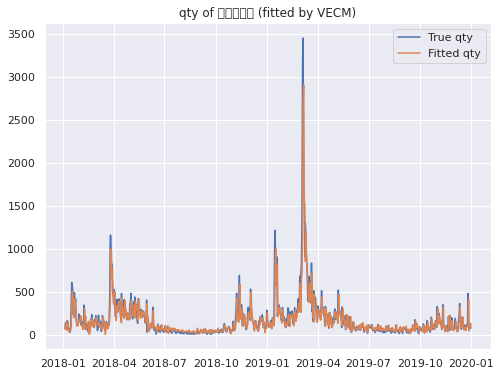

In [198]:
x_len = sh['공기청정기'][3:].index
sns.set()
plt.figure(figsize=(8,6))
plt.title('qty of 공기청정기 (fitted by VECM)')
plt.plot(x_len, sh['공기청정기'][3:], label="True qty")
plt.plot(x_len, vecm_res.fittedvalues[:,1], label="Fitted qty") #적합값..
plt.legend(loc='upper right')

### 1-2-3. final causality

In [48]:
sh_granger = pd.concat([sh_vecm_pivot, sh_var_pivot], axis=1).reset_index()
sh_granger['total'] = np.sum(sh_granger.iloc[:,1:]=='causality', axis=1) # 인과관계가 있는 feature 개수

sh_granger.head()

weather,sm_cat,avg_ta,hm_max,max_pa,max_ta,min_ta,PM10,PM25,avg_ws,sum_ss_hr,total
0,가스온수기,None,None,None,None,None,causality,None,None,None,1
1,가자미,causality,None,None,None,None,None,None,None,None,1
2,감/홍시,None,None,None,None,None,None,None,None,None,0
3,감말랭이,None,None,None,None,None,None,None,None,causality,1
4,갓김치,causality,None,None,causality,causality,causality,None,None,None,4


In [50]:
# sh_granger.to_csv('../data/stationary_causality.csv', encoding='cp949', index=None)

In [51]:
print('인과관계가 하나라도 있는 상품의 개수 : {}'.format(len(sh_granger[sh_granger.total>0].sm_cat)))
print('인과관계가 하나도 없는 상품의 개수 : {}'.format(len(sh_granger[sh_granger.total==0].sm_cat)))

인과관계가 하나라도 있는 상품의 개수 : 89
인과관계가 하나도 없는 상품의 개수 : 41


In [52]:
sh_granger[sh_granger.total>0].sm_cat.unique() # 인과관계가 하나라도 있는 상품

array(['가스온수기', '가자미', '감말랭이', '갓김치', '건강즙/녹용', '건어물 멸치', '건어물 황태', '건자두',
       '견과류', '견과류 땅콩', '견과류 마카다미아', '견과류 잣/은행', '견과류 호두', '공기정화 용품',
       '공기청정기', '과채 음료/주스', '기능성 링클케어 화장품', '기능성 영양보습 화장품',
       '기초 화장용 오일/앰플', '기타 농산물', '기타 한방/환제품', '나물', '남성 스킨', '남성 크림',
       '남성 클렌징', '네일리무버', '네일세트', '네일아트', '네일컬러', '녹차', '닭 양념육', '더치커피',
       '돈풍기', '랍스타', '레몬/자몽', '린스', '멀티형 에어컨', '메이크업 박스', '무/배추',
       '바나나/파인애플/망고', '바디 세트', '반건조고구마', '배/포도/과일즙', '백김치',
       '베이스 메이크업용 BB크림', '베이스 메이크업용 CC크림', '베이스 메이크업용 메이크업베이스',
       '벽걸이형 냉온풍기', '보일러', '뷰티 속눈썹/쌍꺼풀', '뷰티용 기름종이', '뷰티용 뷰러',
       '뷰티용 여드름압출기', '삼치', '색조 메이크업 립글로스', '색조 메이크업 마스카라', '색조 메이크업 볼터치',
       '색조 메이크업 쉐딩/하이라이터', '생수', '샤워코롱', '선크림', '소고기 등심/안심', '수산 생물',
       '스킨케어 코팩', '아몬드유/코코넛밀크', '에이드', '옻/칡/쑥즙', '의류건조기', '이온음료',
       '인스턴트커피', '전복 생물', '절임배추/김치속', '젓갈류', '제습기', '차/곡물 음료', '천장형 에어컨',
       '카페 푸드', '클렌징 크림', '클렌징 폼', '태닝용 선크림', '팩도구', '표고버섯', '풋워시/스크럽',
       '풋크림', '해조류 다시마', '헤어스타일링용 펌제', '헤어케

## 1-3. 비정상 `qty`  


* `ush` = stationary, high corr 

### 1-3-1. 비정상 `qty`와 정상 날씨

#### 공적분 검정

In [14]:
ush_co_res = pd.DataFrame()
for i in range(len(st_weather)):
    w_sample = weather[st_weather[i]]
    res = pd.DataFrame()
    for sm_cat in ush_item:
        res = pd.concat([res, co_test(ush, weather, sm_cat, st_weather[i])], axis=0)
    if i == 0:
        ush_co_res = pd.concat([ush_co_res, res], axis=1)
    else:
        ush_co_res = pd.concat([ush_co_res, res.drop(['sm_cat'], axis=1)], axis=1)

In [15]:
ush_co_res # 정상qty와 비정상날씨 간 공적분이 존재할 경우, vecm 적합 가능

,sm_cat,avg_ws,PM10,PM25,sum_ss_hr
0,가열식 가습기,None,None,None,None
0,갈비/찜/바비큐용 돈육,공적분,None,공적분,None
0,감귤/한라봉/오렌지,None,None,None,None
0,감자,None,None,None,None
0,건대추,None,None,None,None
0,건어물 진미채,None,None,None,None
0,건포도,None,None,None,None
0,게장류,None,None,None,None
0,견과류 밤,None,None,None,None
0,고추/피망/파프리카,None,None,None,None


#### VECM & Granger

In [16]:
warnings.filterwarnings('ignore')
ush_vecm_res = pd.DataFrame()

for w_var in st_weather:
    for sm_cat in ush_item:
        # 공적분 관계가 유의할 때, 그래인저 인과관계 분석
        if (ush_co_res.loc[ush_co_res.sm_cat==sm_cat, w_var] == '공적분').values: 
            result = VECM_granger(ush, weather, sm_cat, w_var)
        else:
            result = pd.DataFrame([{'sm_cat':sm_cat, 'weather':w_var, 'granger_reject':'None'}])
        ush_vecm_res = pd.concat([ush_vecm_res, result], axis=0)

In [17]:
for w in st_weather:
    print('===== Granger Causality : {} ====='.format(w))
    print(ush_vecm_res.loc[ush_vecm_res.weather==w, 'granger_reject'].value_counts())
    print(' ')

===== Granger Causality : avg_ws =====
None    134
Name: granger_reject, dtype: int64
 
===== Granger Causality : PM10 =====
None         132
causality      2
Name: granger_reject, dtype: int64
 
===== Granger Causality : PM25 =====
None         133
causality      1
Name: granger_reject, dtype: int64
 
===== Granger Causality : sum_ss_hr =====
None    134
Name: granger_reject, dtype: int64
 


In [18]:
# 인과관계가 존재하는 경우
ush_vecm_pivot = pd.pivot_table(ush_vecm_res, index='sm_cat', values='granger_reject', columns='weather', aggfunc='first')
ush_vecm_pivot

weather,PM10,PM25,avg_ws,sum_ss_hr
sm_cat,,,,
가열식 가습기,None,None,None,None
갈비/찜/바비큐용 돈육,None,None,None,None
감귤/한라봉/오렌지,None,None,None,None
감자,None,None,None,None
건대추,None,None,None,None
건어물 진미채,None,None,None,None
건포도,None,None,None,None
게장류,None,None,None,None
견과류 밤,None,None,None,None


### 1-3-2. 비정상 `qty`와 비정상 날씨

#### 공적분 검정

In [19]:
ush_co_res2 = pd.DataFrame()
for i in range(len(nst_weather)):
    w_sample = weather[nst_weather[i]]
    res = pd.DataFrame()
    for sm_cat in ush_item:
        res = pd.concat([res, co_test(ush, weather, sm_cat, nst_weather[i])], axis=0)
    if i == 0:
        ush_co_res2 = pd.concat([ush_co_res2, res], axis=1)
    else:
        ush_co_res2 = pd.concat([ush_co_res2, res.drop(['sm_cat'], axis=1)], axis=1)

In [20]:
ush_co_res2

,sm_cat,avg_ta,max_ta,min_ta,hm_max,max_pa
0,가열식 가습기,None,None,None,None,None
0,갈비/찜/바비큐용 돈육,None,None,None,None,공적분
0,감귤/한라봉/오렌지,공적분,공적분,None,None,None
0,감자,None,None,None,None,None
0,건대추,None,None,None,None,None
0,건어물 진미채,None,None,None,None,None
0,건포도,공적분,None,공적분,None,None
0,게장류,None,None,None,None,None
0,견과류 밤,None,None,None,None,None
0,고추/피망/파프리카,None,None,None,None,None


#### VECM & Granger

In [21]:
warnings.filterwarnings('ignore')
ush_vecm_res2 = pd.DataFrame()

for w_var in nst_weather:
    for sm_cat in ush_item:
        # 공적분 관계가 유의할 때, 그래인저 인과관계 분석
        if (ush_co_res2.loc[ush_co_res2.sm_cat==sm_cat, w_var] == '공적분').values: 
            result = VECM_granger(ush, weather, sm_cat, w_var)
        else:
            result = pd.DataFrame([{'sm_cat':sm_cat, 'weather':w_var, 'granger_reject':'None'}])
        ush_vecm_res2 = pd.concat([ush_vecm_res2, result], axis=0)

In [22]:
for w in nst_weather:
    print('===== Granger Causality : {} ====='.format(w))
    print(ush_vecm_res2.loc[ush_vecm_res2.weather==w, 'granger_reject'].value_counts())
    print(' ')

===== Granger Causality : avg_ta =====
None         131
causality      3
Name: granger_reject, dtype: int64
 
===== Granger Causality : max_ta =====
None         131
causality      3
Name: granger_reject, dtype: int64
 
===== Granger Causality : min_ta =====
None    134
Name: granger_reject, dtype: int64
 
===== Granger Causality : hm_max =====
None         133
causality      1
Name: granger_reject, dtype: int64
 
===== Granger Causality : max_pa =====
None    134
Name: granger_reject, dtype: int64
 


In [23]:
ush_vecm_pivot2 = pd.pivot_table(ush_vecm_res2, index='sm_cat', values='granger_reject', columns='weather', aggfunc='first')
ush_vecm_pivot2

weather,avg_ta,hm_max,max_pa,max_ta,min_ta
sm_cat,,,,,
가열식 가습기,None,None,None,None,None
갈비/찜/바비큐용 돈육,None,None,None,None,None
감귤/한라봉/오렌지,None,None,None,None,None
감자,None,None,None,None,None
건대추,None,None,None,None,None
건어물 진미채,None,None,None,None,None
건포도,None,None,None,None,None
게장류,None,None,None,None,None
견과류 밤,None,None,None,None,None


### 1-3-3. Causal features

In [38]:
ush_granger1 = pd.concat([ush_vecm_pivot, ush_vecm_pivot2], axis=1).reset_index()
ush_granger1['total'] = np.sum(ush_granger1.iloc[:,1:]=='causality', axis=1) # 인과관계가 있는 feature 개수
ush_granger1 = ush_granger1.loc[ush_granger1.total>0,:]

ush_granger1 # 5개 실화

weather,sm_cat,PM10,PM25,avg_ws,sum_ss_hr,avg_ta,hm_max,max_pa,max_ta,min_ta,total
49,벽걸이 에어컨,None,None,None,None,causality,None,None,causality,None,2
78,에어컨 리모컨,None,None,None,None,causality,None,None,causality,None,2
88,음용 식초,None,None,None,None,causality,None,None,causality,None,2
90,입욕제,causality,causality,None,None,None,causality,None,None,None,3
123,허브차,causality,None,None,None,None,None,None,None,None,1


### 1-3-4. VAR & Granger 
공적분 관계가 없는 데이터는 차분을 통해 정상 시계열로 만든 뒤 VAR & Granger

In [25]:
ush_item_var = ush_item.copy()
for sm_cat in ush_granger.sm_cat:
    ush_item_var.remove(sm_cat) # VECM을 통해 인과관계를 도출할 수 없었던 sm_cat

In [26]:
def adf_test(data, sm_cat):
    item = data[sm_cat]
    result = adfuller(item.values)
    if result[1] <= 0.05:
        test_res = '정상' # 기각
    else:
        test_res = '비정상' # 기각하지 못함 
    return pd.DataFrame([{'sm_cat':sm_cat, 'ADF_stats':result[0], 'p-value':result[1], 'test_res':test_res}])

In [27]:
def VAR_granger(data, weather, sm_cat, w_var):
    x = pd.concat([weather[w_var], data[sm_cat]], axis=1)
    forecasting_model = VAR(x)
    results_aic = []
    for p in range(1,10):
        results = forecasting_model.fit(p)
        results_aic.append(results.aic)
    model = VAR(x)
    lag = np.argmin(results_aic) + 1
    var_res = model.fit(lag)
    g_res = var_res.test_causality(caused=sm_cat, causing=w_var)
    if g_res.pvalue <= 0.05:
        reject = 'causality'
    else:
        reject = 'None'
    return pd.DataFrame([{'sm_cat':sm_cat, 'weather':w_var, 'var_lag':lag, 'granger_reject':reject}])

#### 정상 날씨

In [30]:
ush_var_res = pd.DataFrame()

for w in st_weather:
    for sm_cat in ush_item_var:
        if (adf_test(ush, sm_cat).test_res=='정상').values:
            result = VAR_granger(ush, weather, sm_cat, w)
        elif (adf_test(weather.diff(1).fillna(0), w).test_res=='정상').values:
            weather_diff = weather.diff(1).fillna(0)
            result = VAR_granger(ush, weather_diff, sm_cat, w)
        else:
            result = pd.DataFrame([{'sm_cat':sm_cat, 'weather':w_var, 'var_lag':lag, 'granger_reject':'None'}])
        ush_var_res = pd.concat([ush_var_res, result], axis=0)

In [31]:
for w in st_weather:
    print('===== Granger Causality : {} ====='.format(w))
    print(ush_var_res.loc[ush_var_res.weather==w, 'granger_reject'].value_counts())
    print(' ')

===== Granger Causality : avg_ws =====
None         116
causality     13
Name: granger_reject, dtype: int64
 
===== Granger Causality : PM10 =====
None         115
causality     14
Name: granger_reject, dtype: int64
 
===== Granger Causality : PM25 =====
None         119
causality     10
Name: granger_reject, dtype: int64
 
===== Granger Causality : sum_ss_hr =====
None         119
causality     10
Name: granger_reject, dtype: int64
 


In [32]:
ush_var_pivot = pd.pivot_table(ush_var_res, index='sm_cat', values='granger_reject', columns='weather', aggfunc='first')
ush_var_pivot

weather,PM10,PM25,avg_ws,sum_ss_hr
sm_cat,,,,
가열식 가습기,causality,causality,causality,None
갈비/찜/바비큐용 돈육,None,None,None,None
감귤/한라봉/오렌지,None,None,None,None
감자,None,None,None,None
건대추,None,None,causality,None
건어물 진미채,causality,None,None,None
건포도,None,None,None,None
게장류,None,None,None,None
견과류 밤,None,causality,None,None


#### 비정상 날씨

In [33]:
ush_var_res2 = pd.DataFrame()

for w in nst_weather:
    for sm_cat in ush_item_var:
        if (adf_test(ush, sm_cat).test_res=='정상').values:
            result = VAR_granger(ush, weather, sm_cat, w)
        elif (adf_test(weather.diff(1).fillna(0), w).test_res=='정상').values:
            weather_diff = weather.diff(1).fillna(0)
            result = VAR_granger(ush, weather_diff, sm_cat, w)
        else:
            result = pd.DataFrame([{'sm_cat':sm_cat, 'weather':w_var, 'var_lag':lag, 'granger_reject':'None'}])
        ush_var_res2 = pd.concat([ush_var_res2, result], axis=0)

In [34]:
for w in nst_weather:
    print('===== Granger Causality : {} ====='.format(w))
    print(ush_var_res2.loc[ush_var_res2.weather==w, 'granger_reject'].value_counts())
    print(' ')

===== Granger Causality : avg_ta =====
None         90
causality    39
Name: granger_reject, dtype: int64
 
===== Granger Causality : max_ta =====
None         99
causality    30
Name: granger_reject, dtype: int64
 
===== Granger Causality : min_ta =====
None         96
causality    33
Name: granger_reject, dtype: int64
 
===== Granger Causality : hm_max =====
None         96
causality    33
Name: granger_reject, dtype: int64
 
===== Granger Causality : max_pa =====
None         119
causality     10
Name: granger_reject, dtype: int64
 


In [35]:
ush_var_pivot2 = pd.pivot_table(ush_var_res2, index='sm_cat', values='granger_reject', columns='weather', aggfunc='first')
ush_var_pivot2

weather,avg_ta,hm_max,max_pa,max_ta,min_ta
sm_cat,,,,,
가열식 가습기,causality,causality,None,causality,causality
갈비/찜/바비큐용 돈육,None,None,None,None,None
감귤/한라봉/오렌지,causality,causality,None,None,causality
감자,None,None,None,None,None
건대추,None,None,None,None,causality
건어물 진미채,None,None,None,None,None
건포도,None,None,None,None,None
게장류,None,None,None,None,None
견과류 밤,None,None,None,None,None


#### Causal features

In [40]:
ush_granger2 = pd.concat([ush_var_pivot, ush_var_pivot2], axis=1).reset_index()
ush_granger2['total'] = np.sum(ush_granger2.iloc[:,1:]=='causality', axis=1) # 인과관계가 있는 feature 개수

ush_granger2 

weather,sm_cat,PM10,PM25,avg_ws,sum_ss_hr,avg_ta,hm_max,max_pa,max_ta,min_ta,total
0,가열식 가습기,causality,causality,causality,None,causality,causality,None,causality,causality,7
1,갈비/찜/바비큐용 돈육,None,None,None,None,None,None,None,None,None,0
2,감귤/한라봉/오렌지,None,None,None,None,causality,causality,None,None,causality,3
3,감자,None,None,None,None,None,None,None,None,None,0
4,건대추,None,None,causality,None,None,None,None,None,causality,2
5,건어물 진미채,causality,None,None,None,None,None,None,None,None,1
6,건포도,None,None,None,None,None,None,None,None,None,0
7,게장류,None,None,None,None,None,None,None,None,None,0
8,견과류 밤,None,causality,None,None,None,None,None,None,None,1
9,고추/피망/파프리카,None,None,None,None,None,None,None,None,None,0


### 1-3-5. final causality (vecm + var)

In [49]:
ush_granger = pd.concat([ush_granger1, ush_granger2], axis=0)
ush_granger.head()

weather,sm_cat,PM10,PM25,avg_ws,sum_ss_hr,avg_ta,hm_max,max_pa,max_ta,min_ta,total
49,벽걸이 에어컨,None,None,None,None,causality,None,None,causality,None,2
78,에어컨 리모컨,None,None,None,None,causality,None,None,causality,None,2
88,음용 식초,None,None,None,None,causality,None,None,causality,None,2
90,입욕제,causality,causality,None,None,None,causality,None,None,None,3
123,허브차,causality,None,None,None,None,None,None,None,None,1


In [55]:
ush_granger.to_csv('../data/nonstationary_causality.csv', encoding='cp949', index=None)

In [51]:
print('인과관계가 하나라도 있는 상품의 개수 : {}'.format(len(ush_granger[ush_granger.total>0].sm_cat)))
print('인과관계가 하나도 없는 상품의 개수 : {}'.format(len(ush_granger[ush_granger.total==0].sm_cat)))

인과관계가 하나라도 있는 상품의 개수 : 77
인과관계가 하나도 없는 상품의 개수 : 57


In [52]:
ush_granger[ush_granger.total>0].sm_cat.unique() # 인과관계가 하나라도 있는 상품

array(['벽걸이 에어컨', '에어컨 리모컨', '음용 식초', '입욕제', '허브차', '가열식 가습기',
       '감귤/한라봉/오렌지', '건대추', '건어물 진미채', '견과류 밤', '곡물차', '기능성 아이케어 화장품',
       '기능성 화장품 세트', '기초 화장용 로션', '기초 화장용 미스트', '기초 화장용 크림', '기타 주스류',
       '난방용 열풍기', '남성 세트', '남성 쉐이빙', '느타리버섯', '데오드란트', '둥굴레차',
       '딸기/복분자/블루베리', '라디에이터', '루테인/눈 영양제', '명태/동태', '바디 보습제', '바디 클렌져',
       '바디케어용 땀패드', '바디케어용 제모제', '보리차', '복합식 가습기', '부추', '브로콜리/셀러리',
       '비타민', '색조 메이크업 립밤', '색조 메이크업 아이섀도우', '선스프레이', '선케어용 선밤', '소고기 육회',
       '쌈채소', '양배추/양상추', '어린이영양제', '에어워셔', '오메가3/스쿠알렌 영양제', '온수매트',
       '온열매트', '온풍기', '요거트/발효유', '유자차', '율무차', '자연식 가습기', '잡곡 씨드류', '장어',
       '전기온수기', '전기장판', '초음파식 가습기', '초코우유', '카페트매트', '칼슘/철분 영양제',
       '캡슐/POD커피', '컨벡터', '코코아/핫초코', '콜라겐/코큐텐 영양제', '클렌징 로션',
       '탁상/USB 선풍기', '탄산수', '파/양파', '파김치', '포도/거봉/체리', '프로폴리스/로얄젤리',
       '해초류 ', '핸드크림', '황토매트', '휴대용 선풍기', '히터'], dtype=object)